In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
from numpy.linalg import svd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
import librosa
import librosa.display
from src import utils
from tensorflow.keras import Sequential

plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('./data/fma_small/')


In [4]:
# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [5]:
tracks['album'].head()

,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


In [6]:
tracks['track'].head()

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [7]:
tracks['track'].columns



Index(['bit_rate', 'comments', 'composer', 'date_created', 'date_recorded',
       'duration', 'favorites', 'genre_top', 'genres', 'genres_all',
       'information', 'interest', 'language_code', 'license', 'listens',
       'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')

In [8]:
filename = utils.get_audio_path('data/fma_small', 110000)


In [10]:
audio_files = []
for i in range(5000):
#for i in index:
    filename = utils.get_audio_path('data/fma_small',i)
    if os.path.isfile(filename):
        x, sr = librosa.load(filename, sr=None, mono=True)
        audio_files.append([i, x[:1000000], sr])


/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.8/site-packages/librosa/cor

In [6]:
small_df = tracks['track'][tracks['track'].index.isin([row[0] for row in audio_files])]

In [10]:
index = [row[0] for row in audio_files]

In [12]:
l = [row[1] for row in audio_files] 

In [ ]:
np.stack(l)

In [13]:
svd = TruncatedSVD(n_components=100, random_state = 42)
svd.fit(l)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: Expected 2D array, got 1D array instead:
array=[array([ 0.        ,  0.        ,  0.        , ..., -0.24734497,
       -0.19889832, -0.10516357], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.09512329, 0.09672546,
       0.09130859], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01448059,
        0.03410339,  0.088974  ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.16525269, 0.16116333,
       0.15609741], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.20878601,
       -0.19250488, -0.14735413], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.7239075 ,
       -0.6913452 , -0.64146423], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.28631592, 0.27394104,
       0.25086975], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.10031128, 0.08744812,
       0.06622314], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.10049438,
       -0.10464478, -0.098526  ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.17747498,
       -0.18299866, -0.1900177 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02584839, 0.02801514,
       0.03051758], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.04017639, 0.03872681,
       0.03312683], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.13882446, 0.13723755,
       0.13537598], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.19737244,
       -0.18338013, -0.1726532 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01164246,
       -0.01161194, -0.01193237], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.06520081, 0.06636047,
       0.06719971], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.07022095, 0.08250427,
       0.09480286], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.40618896,
       -0.37635803, -0.3361206 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.1303711 ,
       -0.11827087, -0.10714722], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.13600159, 0.0909729 ,
       0.04603577], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03041077, 0.08096313,
       0.11512756], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.04554749, 0.04551697,
       0.04649353], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01315308,
       -0.02938843, -0.04367065], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.38549805, 0.39543152,
       0.45303345], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0091095 ,
       -0.00952148, -0.0098877 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.06262207, 0.05964661,
       0.0567627 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01243591, 0.01036072,
       0.00714111], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.24311829,
       -0.30836487, -0.35380554], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.02032471,
       -0.01992798, -0.01937866], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.13555908,
       -0.1348114 , -0.13424683], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.12136841,
       -0.12162781, -0.12037659], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.11723328,
       -0.04388428, -0.22102356], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.18319702, 0.19781494,
       0.20603943], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.10525513,
       -0.10202026, -0.09216309], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.2418518 ,
       -0.2366333 , -0.23043823], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03997803,
        0.05761719, -0.00553894], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.22169495, 0.2998352 ,
       0.2524109 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00042725,
        0.02433777,  0.03106689], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.0534668 , 0.07369995,
       0.06584167], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.30662537, 0.3536377 ,
       0.3816986 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.22509766, 0.1898346 ,
       0.17079163], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.07348633,
       -0.0844574 , -0.06762695], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.18103027, 0.19039917,
       0.19206238], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.2140503 ,
       -0.22154236, -0.23136902], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03533936, 0.06881714,
       0.10629272], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.44833374, 0.45492554,
       0.43977356], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.11639404, 0.11402893,
       0.11351013], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.31999207, 0.3079834 ,
       0.29014587], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.012146  ,
        0.01794434, -0.01115417], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.18411255,
       -0.18119812, -0.1855011 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.17713928, 0.16941833,
       0.15847778], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.07820129, 0.08117676,
       0.08372498], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.16160583, 0.1678009 ,
       0.1723938 ], dtype=float32)
 array([-0.3951416 , -0.45507812, -0.51368713, ..., -0.31802368,
       -0.30503845, -0.24472046], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.1741333 , 0.15966797,
       0.14648438], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.00541687, 0.00559998,
       0.00460815], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04769897,
       -0.06886292, -0.0912323 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.20446777, 0.215271  ,
       0.20281982], dtype=float32)
 array([ 0.       ,  0.       ,  0.       , ..., -0.2824707, -0.3176117,
       -0.3327942], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.6078186 ,
       -0.62590027, -0.6376953 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01785278,
       -0.37680054, -0.46247864], dtype=float32)
 array([0.       , 0.       , 0.       , ..., 0.2897339, 0.2572937,
       0.2525177], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.24928284, 0.28048706,
       0.32254028], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.37179565,
       -0.31195068, -0.29458618], dtype=float32)
 array([0.       , 0.       , 0.       , ..., 0.2752533, 0.2771454,
       0.2823944], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.12538147, 0.12696838,
       0.13549805], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.05534363,
       -0.0587616 ,  0.00564575], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.07394409,
       -0.04051208, -0.07475281], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.08111572,
       -0.04595947, -0.00967407], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.26553345, 0.28147888,
       0.31228638], dtype=float32)
 array([0.       , 0.       , 0.       , ..., 0.7034607, 0.6336975,
       0.58638  ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.15016174,
       -0.14602661, -0.14805603], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.28311157,
       -0.29464722, -0.2992401 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.08932495, 0.09158325,
       0.09335327], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.11471558,
       -0.11657715, -0.12081909], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.08836365, 0.09474182,
       0.10122681], dtype=float32)
 array([ 0.,  0.,  0., ..., -1., -1., -1.], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.72558594,
       -0.72540283, -0.7139435 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.0559082 , 0.06332397,
       0.05628967], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.311615  , 0.45539856,
       0.52885437], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0406189 ,
       -0.02520752, -0.01812744], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01057434, 0.00126648,
       0.00285339], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.1377716 , 0.10279846,
       0.07511902], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02087402, 0.02159119,
       0.02319336], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.13012695,
       -0.09565735, -0.07006836], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.04193115, 0.04200745,
       0.04006958], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01333618, 0.00601196,
       0.01324463], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.05999756,
        0.02758789, -0.00750732], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.12341309, 0.12916565,
       0.13519287], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.1511383 ,
       -0.18374634, -0.2217102 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03677368,
       -0.06185913, -0.00257874], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.35897827,
       -0.4079132 , -0.41870117], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01992798,
       -0.01760864, -0.01965332], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.19700623, 0.1952362 ,
       0.18344116], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00357056,
       -0.003479  , -0.00245667], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.24667358, 0.23855591,
       0.22706604], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.09506226,
       -0.10862732, -0.12750244], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.16725159,
       -0.14341736, -0.1156311 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.18554688,
       -0.1643219 , -0.14730835], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.07806396, 0.09965515,
       0.10159302], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.18630981, 0.20857239,
       0.2142334 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.0644989 , 0.04785156,
       0.0499115 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01591492, 0.0327301 ,
       0.04260254], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.22633362,
       -0.22938538, -0.25332642], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.22595215, 0.22364807,
       0.21748352], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.09172058, 0.11323547,
       0.11961365], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04679871,
       -0.05154419, -0.0559845 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01538086, 0.00700378,
       0.00436401], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.07362366,
       -0.03768921,  0.01525879], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.11192322,
       -0.04615784,  0.03335571], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.04446411,
       -0.03163147, -0.07661438], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.01359558,
       -0.00067139,  0.02125549], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.4287567 , 0.41688538,
       0.4124756 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.14224243, 0.12857056,
       0.14190674], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06500244,
       -0.06285095, -0.04859924], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.06564331, 0.0796814 ,
       0.06768799], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.12167358, 0.12159729,
       0.12619019], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04959106,
       -0.05441284, -0.05807495], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.40097046,
       -0.44499207, -0.4457245 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.2687378 ,
       -0.25109863, -0.23539734], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.06314087, 0.08190918,
       0.09976196], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03540039, 0.03684998,
       0.03175354], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.19303894,
       -0.24282837, -0.30296326], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02050781, 0.02853394,
       0.03770447], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.19570923, 0.20605469,
       0.21607971], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.0276947 ,
        0.00662231, -0.0138855 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.04470825, 0.05273438,
       0.06230164], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.06878662, 0.06471252,
       0.06015015], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.0574646 , 0.05485535,
       0.05239868], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.08021545, 0.07037354,
       0.05953979], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04800415,
       -0.03042603, -0.01565552], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03219604, 0.03479004,
       0.03642273], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.10472107, 0.10531616,
       0.11471558], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.04225159, 0.04586792,
       0.05877686], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00848389,
       -0.00289917,  0.00144958], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.06565857, 0.06167603,
       0.06085205], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.1401062 ,
       -0.14118958, -0.14353943], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00924683,
       -0.01123047, -0.01289368], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.02217102,
       -0.03016663, -0.03594971], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00746155,
       -0.00776672, -0.00798035], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01222229, 0.01301575,
       0.01371765], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01580811,
       -0.03886414, -0.05786133], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0415802 ,
       -0.04737854, -0.03059387], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.10740662, 0.11309814,
       0.11611938], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06594849,
       -0.08670044, -0.10353088], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.09114075,
       -0.09037781, -0.09135437], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06222534,
       -0.07296753, -0.07620239], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.10523987,
       -0.11390686, -0.12371826], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.157547  ,
       -0.15412903, -0.14585876], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.3859253 , 0.39163208,
       0.3937683 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.38409424, 0.34928894,
       0.31610107], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01292419,
       -0.01832581, -0.03416443], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.0763855 , 0.08596802,
       0.09242249], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02879333, 0.02571106,
       0.02313232], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.05584717, 0.08560181,
       0.11941528], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.21528625,
       -0.18762207, -0.15403748], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01501465, 0.01548767,
       0.02116394], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02407837, 0.01664734,
       0.00813293], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03475952, 0.03936768,
       0.04704285], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.08232117, 0.07119751,
       0.08679199], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.14675903, 0.1559143 ,
       0.14440918], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06921387,
       -0.06742859, -0.06343079], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0027771 ,
       -0.00260925, -0.00271606], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.16513062,
       -0.21025085, -0.14424133], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.15766907,
       -0.16345215, -0.16981506], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06689453,
       -0.06288147, -0.05770874], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01997375, 0.01313782,
       0.01197815], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.09020996, 0.0980835 ,
       0.10922241], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.934021  ,
       -0.9430084 , -0.95170593], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.02653503,
       -0.05979919, -0.08390808], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.24552917,
       -0.24043274, -0.22355652], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.17054749, 0.16970825,
       0.16799927], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.4117279 ,
       -0.39237976, -0.38009644], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01620483,
       -0.01290894, -0.01159668], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.11204529, 0.11091614,
       0.12190247], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03535461,
       -0.01966858,  0.00497437], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.23451233,
       -0.23718262, -0.24285889], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04263306,
       -0.03903198, -0.03567505], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.05700684,
       -0.05331421, -0.05108643], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03727722, 0.03833008,
       0.04200745], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00358582,
       -0.00416565, -0.00465393], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.02389526,
       -0.02444458, -0.02510071], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.1199646 ,
       -0.11584473, -0.10192871], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.07600403, 0.07827759,
       0.08058167], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06285095,
       -0.06034851, -0.05780029], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03564453,
       -0.03405762, -0.03240967], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03109741, 0.0309906 ,
       0.03071594], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03286743,
       -0.03823853, -0.04125977], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04512024,
       -0.02180481, -0.0042572 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.13635254, 0.14648438,
       0.14872742], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03086853,
        0.03916931,  0.0839386 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.00213623, 0.00479126,
       0.00662231], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.00976562,
       -0.03297424, -0.1096344 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.13902283,
       -0.14944458, -0.22235107], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.01803589,
        0.00621033, -0.01327515], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.00180054, 0.004776  ,
       0.01679993], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.07702637,
       -0.07603455, -0.07862854], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.2833557 , 0.29995728,
       0.2973938 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03945923,
       -0.08364868, -0.06646729], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00323486,
        0.0039978 ,  0.01142883], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0027771 ,
       -0.02375793, -0.04559326], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.09291077, 0.10606384,
       0.09216309], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.15939331, 0.14207458,
       0.12585449], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.04653931, 0.04544067,
       0.04548645], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.30711365, 0.323761  ,
       0.33047485], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.00735474,
       -0.0022583 , -0.00448608], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00794983,
       -0.00421143,  0.00036621], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02409363, 0.02099609,
       0.02284241], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.2185669 ,
       -0.22290039, -0.22143555], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03997803, 0.04386902,
       0.04855347], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03448486,
       -0.03204346, -0.02555847], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.0958252 , 0.10536194,
       0.12593079], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.11235046, 0.10717773,
       0.09275818], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02598572, 0.0308075 ,
       0.03703308], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02496338, 0.02565002,
       0.02319336], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.03901672,
       -0.0433197 , -0.04838562], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.02400208, 0.02432251,
       0.02629089], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.00024414,
       -0.00209045, -0.00526428], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.00546265,
        0.00363159, -0.0415802 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.0045166 ,
        0.00064087, -0.00291443], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.15414429,
       -0.15159607, -0.14718628], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01358032, 0.01249695,
       0.0111084 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.11274719, 0.10118103,
       0.088974  ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.04084778,
       -0.08370972, -0.07684326], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.09130859, 0.18037415,
       0.2515564 ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.00080872, 0.02812195,
       0.0448761 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.07368469,
       -0.06655884, -0.06987   ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.08888245, 0.08834839,
       0.08320618], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.02986145,
       -0.03379822, -0.03495789], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.18777466,
       -0.17185974, -0.13444519], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0816803 ,
       -0.09243774, -0.11579895], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.01516724,
       -0.00601196, -0.00657654], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.01748657,
       -0.0110321 , -0.00588989], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.0916748 ,
        0.05311584, -0.00318909], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.03256226, 0.032547  ,
       0.03660583], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.20558167,
       -0.25393677, -0.2534485 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0226593 ,
       -0.00640869,  0.01667786], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.1005249 ,
       -0.12297058, -0.14224243], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.05903625, 0.06985474,
       0.07470703], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.4373474 , 0.34623718,
       0.18041992], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.0196228 ,
       -0.02101135, -0.02613831], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.11808777,
       -0.11984253, -0.1209259 ], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.27139282,
       -0.25959778, -0.22276306], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ...,  0.08609009,
        0.02400208, -0.04121399], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.05883789, 0.07035828,
       0.07879639], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.16105652,
       -0.16287231, -0.18331909], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.18678284, 0.23323059,
       0.31980896], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.4272766 ,
       -0.40370178, -0.374115  ], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.00080872, 0.00100708,
       0.00099182], dtype=float32)
 array([0.        , 0.        , 0.        , ..., 0.01716614, 0.02070618,
       0.02412415], dtype=float32)
 array([ 0.        ,  0.        ,  0.        , ..., -0.06202698,
       -0.07649231, -0.08537292], dtype=float32)].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
srs = [row[2] for row in audio_files]

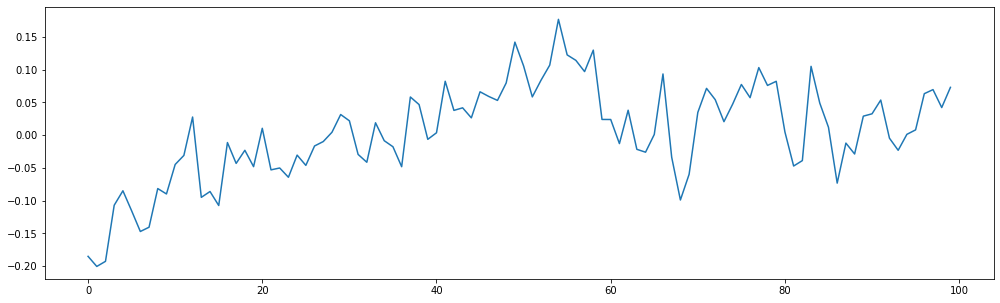

In [20]:
plt.plot(l[0][5500:5600])

In [ ]:
X = np.concatenate([row[1] for row in audio_files], axis = None)

In [ ]:
small_df.to_csv('data/small_audio_df')

In [11]:
small_df['genre_top'] = small_df['genre_top'].apply(lambda x: 1 if x == 'Folk' else 0)

In [12]:
y = small_df['genre_top']
X = [row[1] for row in audio_files]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
model = Sequential()
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.fit(X_train,
          y_train,
          batch_size=100,
          epochs=5,
          verbose=1, 
          validation_data=(X_test, y_test))

In [19]:
x, sr = librosa.load('data/fma_small/000/000005.mp3', sr=None, mono=True)

/Users/alextsai/gal/capstones/capstone_2/music_audio_analysis/env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [20]:
x.shape

(1323648,)

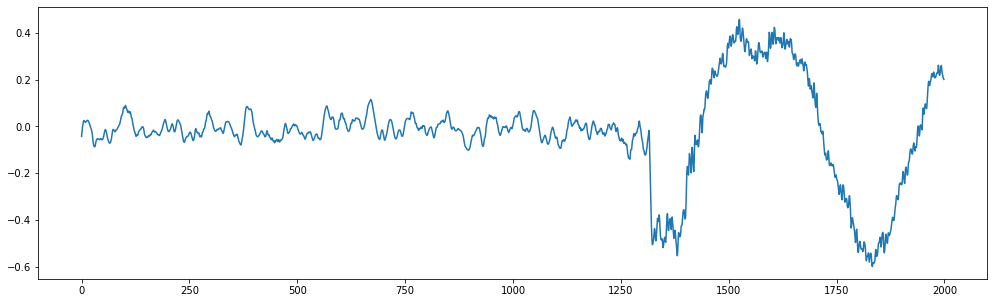

In [21]:
plt.plot(x[3000:5000])

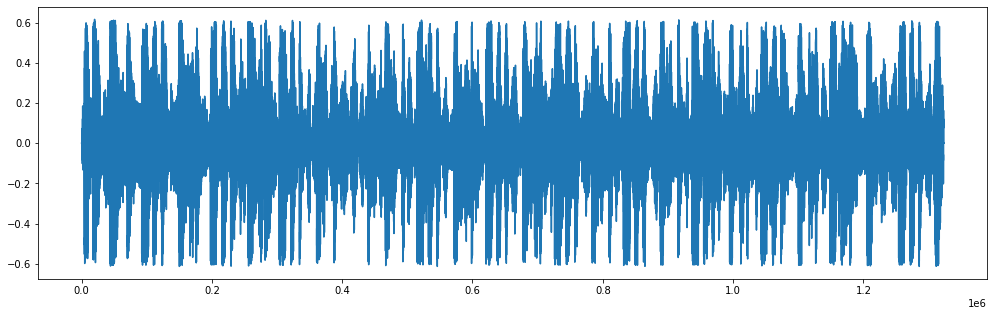

In [22]:
plt.plot(x)

In [22]:
ipd.Audio(data=l[0],rate = srs[0])